In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
size_functions = 128
lambda_c = 1e-4
not_sgd = True
if not_sgd:
  alpha = 0.01
  nb_epoch = 10000
else:
  alpha = 0.5
  nb_epoch = 100000

In [ ]:
def generate_functions(size=128):
  df=[]
  for k in range(size+1):
    function_k = np.ones((size))
    for i in range(k):
      function_k[i] = 0
    df.append(function_k)
  return np.array(df)

In [ ]:
def visualization_step_function(step_function):
  plt.plot(step_function)

def full_visualization(X, X_bis=np.empty(0), w=10):
  fig, axs = plt.subplots(math.ceil(X.shape[0]/w), w,figsize=(w*2,math.ceil(X.shape[0]/w)*2.2))
  for k in range (X.shape[0]):
    axs[k//w, k%w].plot(X[k])
    #axs[k//w, k%w].plot(X[k], marker='.', linestyle=None)
    if not X_bis.size == 0:
      axs[k//w, k%w].plot(X_bis[k])
      #axs[k//w, k%w].plot(X_bis[k], marker='.', linestyle=None)
    axs[k//w, k%w].set_title(str(k), y=0.99)


In [ ]:
X_np = generate_functions(size_functions)
X = torch.from_numpy(X_np).float()
print(X.shape)
print(X)
#visualization_step_function(X[64])
X_partial = torch.from_numpy(np.concatenate((X_np[:40],X_np[70:]))).float()
print(X_partial.shape)
print(X_partial)

torch.Size([129, 128])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([99, 128])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
#full_visualization(X_np)

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self,size_functions):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(size_functions,1) # encoder
        self.fc2 = nn.Linear(1,size_functions) # decoder
    def forward(self,X):
        A0 = X
        A1 = F.leaky_relu(self.fc1(X))  
        A2 = F.sigmoid(self.fc2(A1))
        return A2

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

class Encoder(nn.Module):
    def __init__(self,size_functions):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(size_functions,1,bias=False) # encoder
        #self.fc1 = nn.Linear(size_functions,1)
    def forward(self,X):
        A0 = X
        A1 = (self.fc1(X))
        #A1 = F.leaky_relu(self.fc1(X))
        return A1

class Decoder(nn.Module):
    def __init__(self,size_functions):
        super(Decoder, self).__init__()
        self.fc2 = nn.Linear(1,size_functions) # decoder
    def forward(self,X):
        A0 = X
        A2 = F.sigmoid(self.fc2(A0))
        return A2

class Autoencoder_splitted(nn.Module):
    def __init__(self,size_functions):
        super(Autoencoder_splitted, self).__init__()
        self.encoder = Encoder(size_functions)
        self.decoder = Decoder(size_functions)

    def forward(self, x):
        z = self.encoder(x)
        return z, self.decoder(z)

In [ ]:
def contractive_loss(outputs_e, outputs, targets, lambda_c = 1e-4, lambda_mse = 1):
    
    criterion = nn.MSELoss()
    loss_mse = criterion(outputs, targets)
    
    outputs_e.backward(torch.ones(outputs_e.size()), retain_graph=True)    
    # Frobenious norm, the square root of sum of all elements (square value)
    # in a jacobian matrix 
    loss_c = torch.sqrt(torch.sum(torch.pow(targets.grad,2)))
    targets.grad.data.zero_()
    loss = (lambda_mse*loss_mse) + (lambda_c*loss_c) 
    return loss, loss_mse, loss_c

def contractive_loss_2 (outputs_e, outputs, targets, m_encoder, lambda_c, lambda_mse = 1):
  """
  Actual function computing the loss of a contractive autoencoder
  :param input: (Tensor)
  :param target: (Tensor)
  :param lambd: (float) regularization parameter
  :param ae: (DeepAutoencoder) the model itself, used to get it's weights
  :param reduction: (str) type of reduction {'mean' | 'sum'}
  :raises: ValueError
  :return: the loss
  """
  criterion = nn.MSELoss()
  loss_mse = criterion(outputs, targets)
  dh = outputs_e * (1-outputs_e)
  W = m_encoder.fc1.weight
  #print(W)
  #enc_weights = [ae.encoder[i].weight for i in reversed(range(1, len(ae.encoder), 2))]
  #loss_c = torch.norm(torch.chain_matmul(*enc_weights))
  loss_c = torch.norm(torch.matmul(dh**2, torch.square(W)))
  loss = (lambda_mse*loss_mse) + (lambda_c*loss_c) 
  return loss, loss_mse, loss_c

In [ ]:
model = Autoencoder_splitted(size_functions)

In [ ]:
if not_sgd:
  optimizer = torch.optim.RMSprop(model.parameters(), lr=alpha)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0, loss 0.2689257860183716


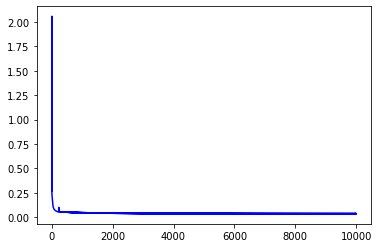

In [ ]:
loss_l = []
hist_mse = []
hist_c = []
for num_epoch in range(nb_epoch):
  
  #X.requires_grad_(True)
  #X.retain_grad()
  pred_E, X_predicted = model(X) #Pass through autoencoder
  #loss, loss_mse, loss_c = contractive_loss(pred_E, X_predicted, X)
  loss, loss_mse, loss_c = contractive_loss_2(pred_E, X_predicted, X, model.encoder, lambda_c)
  """
  if num_epoch < 5000:
    loss, loss_mse, loss_c = contractive_loss_2(pred_E, X_predicted, X, model.encoder)
  else:
    loss, loss_mse, loss_c = contractive_loss(pred_E, X_predicted, X, lambda_c=0)
  """
  #X.requires_grad_(False)

  # Zero gradients, perform a backward pass, and update the weights. 
  optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
  loss.backward() # perform back-propagation
  optimizer.step() # update the weights
  loss_l.append(loss)
  hist_mse.append(loss_mse)
  hist_c.append(loss_c*lambda_c)
  if num_epoch % 10000 == 0:
      print('epoch {}, loss {}'.format(num_epoch, loss.item()))
plt.plot(loss_l, color='b')
#plt.plot(hist_mse, color='g')
#plt.plot(hist_c, color='r')


In [ ]:
model_partial = Autoencoder_splitted(size_functions)
criterion_partial = nn.MSELoss()

if not_sgd:
  optimizer_partial = torch.optim.RMSprop(model_partial.parameters(), lr=alpha)
else:
  optimizer_partial = torch.optim.SGD(model_partial.parameters(), lr=alpha)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Partial : epoch 0, loss 0.28296470642089844


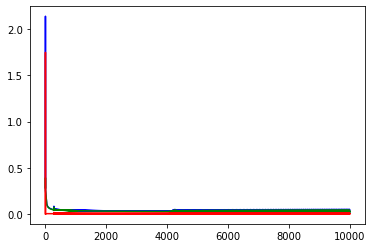

In [ ]:
loss_partial = []
hist_mse_partial = []
hist_c_partial = []
for num_epoch in range(nb_epoch):

  #X_partial.requires_grad_(True)
  #X_partial.retain_grad()
  pred_E_partial, X_predicted_partial = model_partial(X_partial) #Pass through autoencoder
  """
  if num_epoch < 5000:
    loss_2, loss_mse, loss_c = contractive_loss(pred_E_partial, X_predicted_partial, X_partial)
  else:
    loss_2, loss_mse, loss_c = contractive_loss(pred_E_partial, X_predicted_partial, X_partial, lambda_mse=0)
  #loss_2 = contractive_loss(pred_E_partial, X_predicted_partial, X_partial)
  """
  loss_2, loss_mse, loss_c = contractive_loss_2(pred_E_partial, X_predicted_partial, X_partial, model_partial.encoder, lambda_c)
  #X_partial.requires_grad_(False)

  #_, X_predicted_partial = model_partial(X)
  #loss_2 = criterion_partial(X_predicted_partial, X) 
  # Zero gradients, perform a backward pass, and update the weights. 
  optimizer_partial.zero_grad() # re-init the gradients (otherwise they are cumulated)
  loss_2.backward() # perform back-propagation
  optimizer_partial.step() # update the weights
  loss_partial.append(loss_2)
  hist_mse_partial.append(loss_mse)
  hist_c_partial.append(loss_c*lambda_c)
  if num_epoch % 10000 == 0:
      print('Partial : epoch {}, loss {}'.format(num_epoch, loss_2.item()))

plt.plot(loss_partial, color='b')
plt.plot(hist_mse_partial, color='g')
plt.plot(hist_c_partial, color='r')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


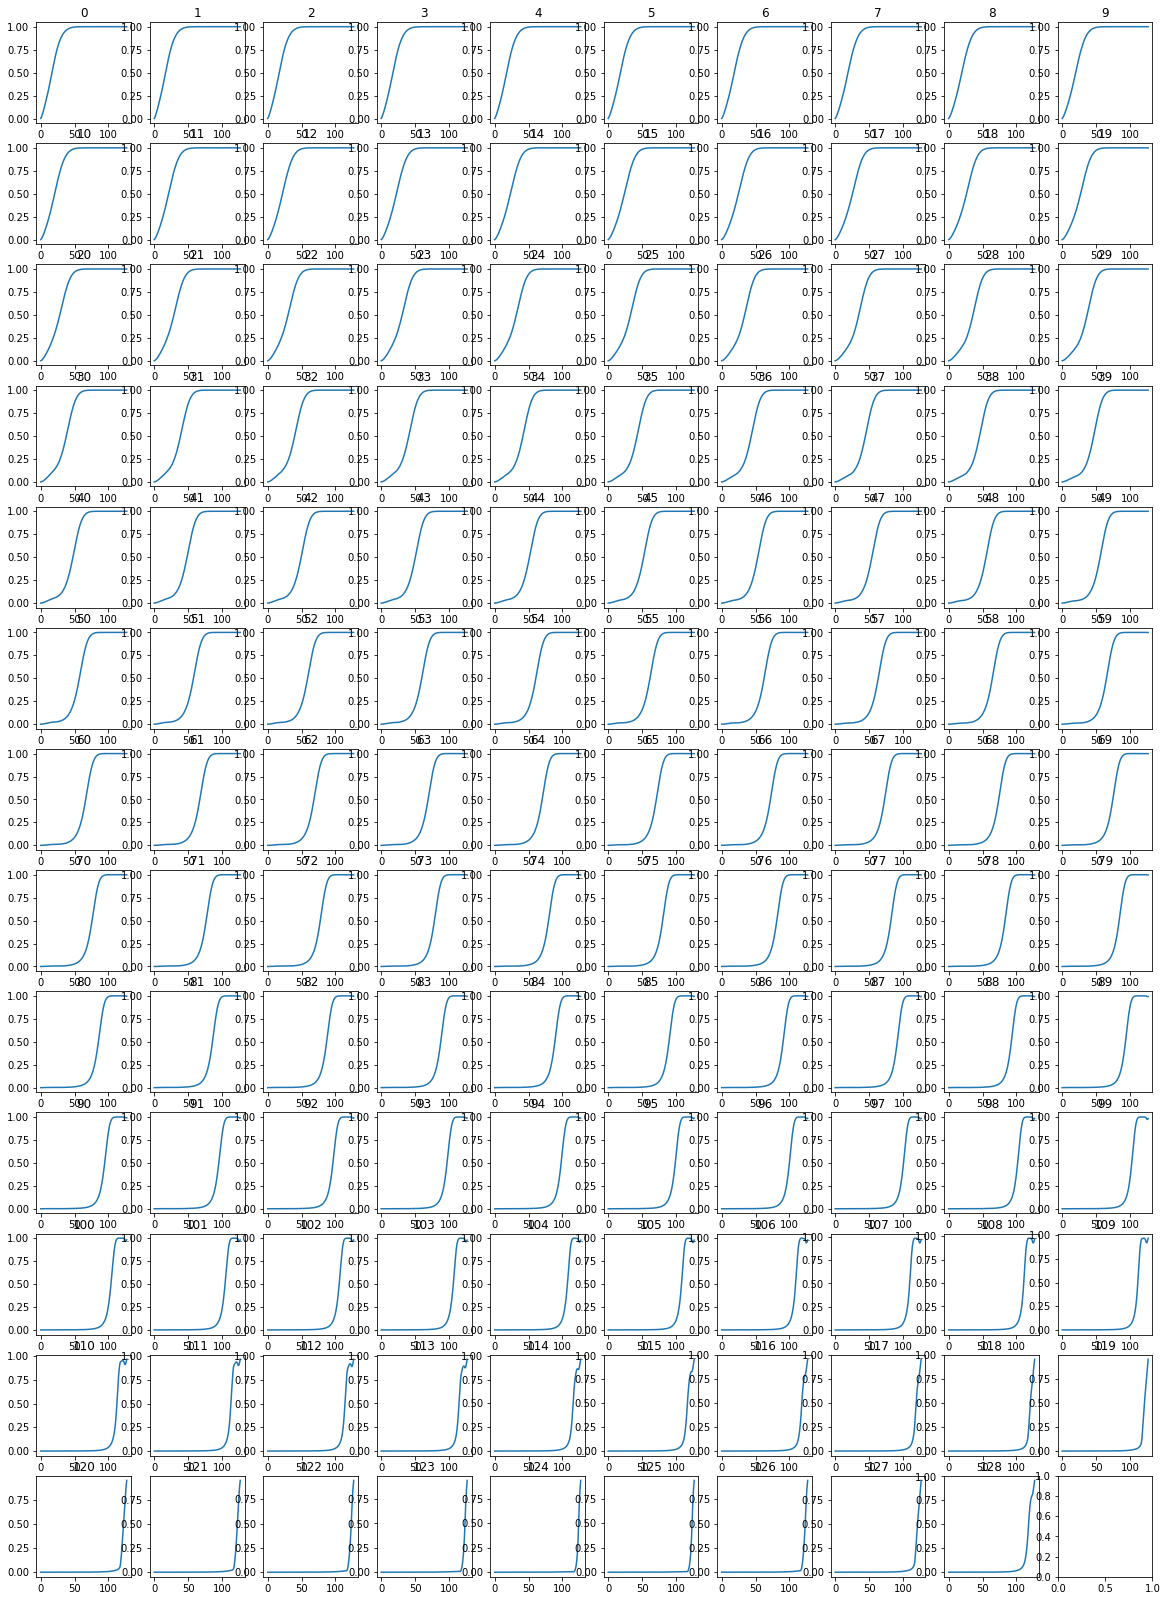

In [ ]:
activation = {}

activation_full, X_predicted = model(X)

X_predicted = X_predicted.detach().numpy()
activation_full = activation_full.detach().numpy()
#activation_full = model.encoder(X).detach().numpy()
#Print
full_visualization(X_predicted)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


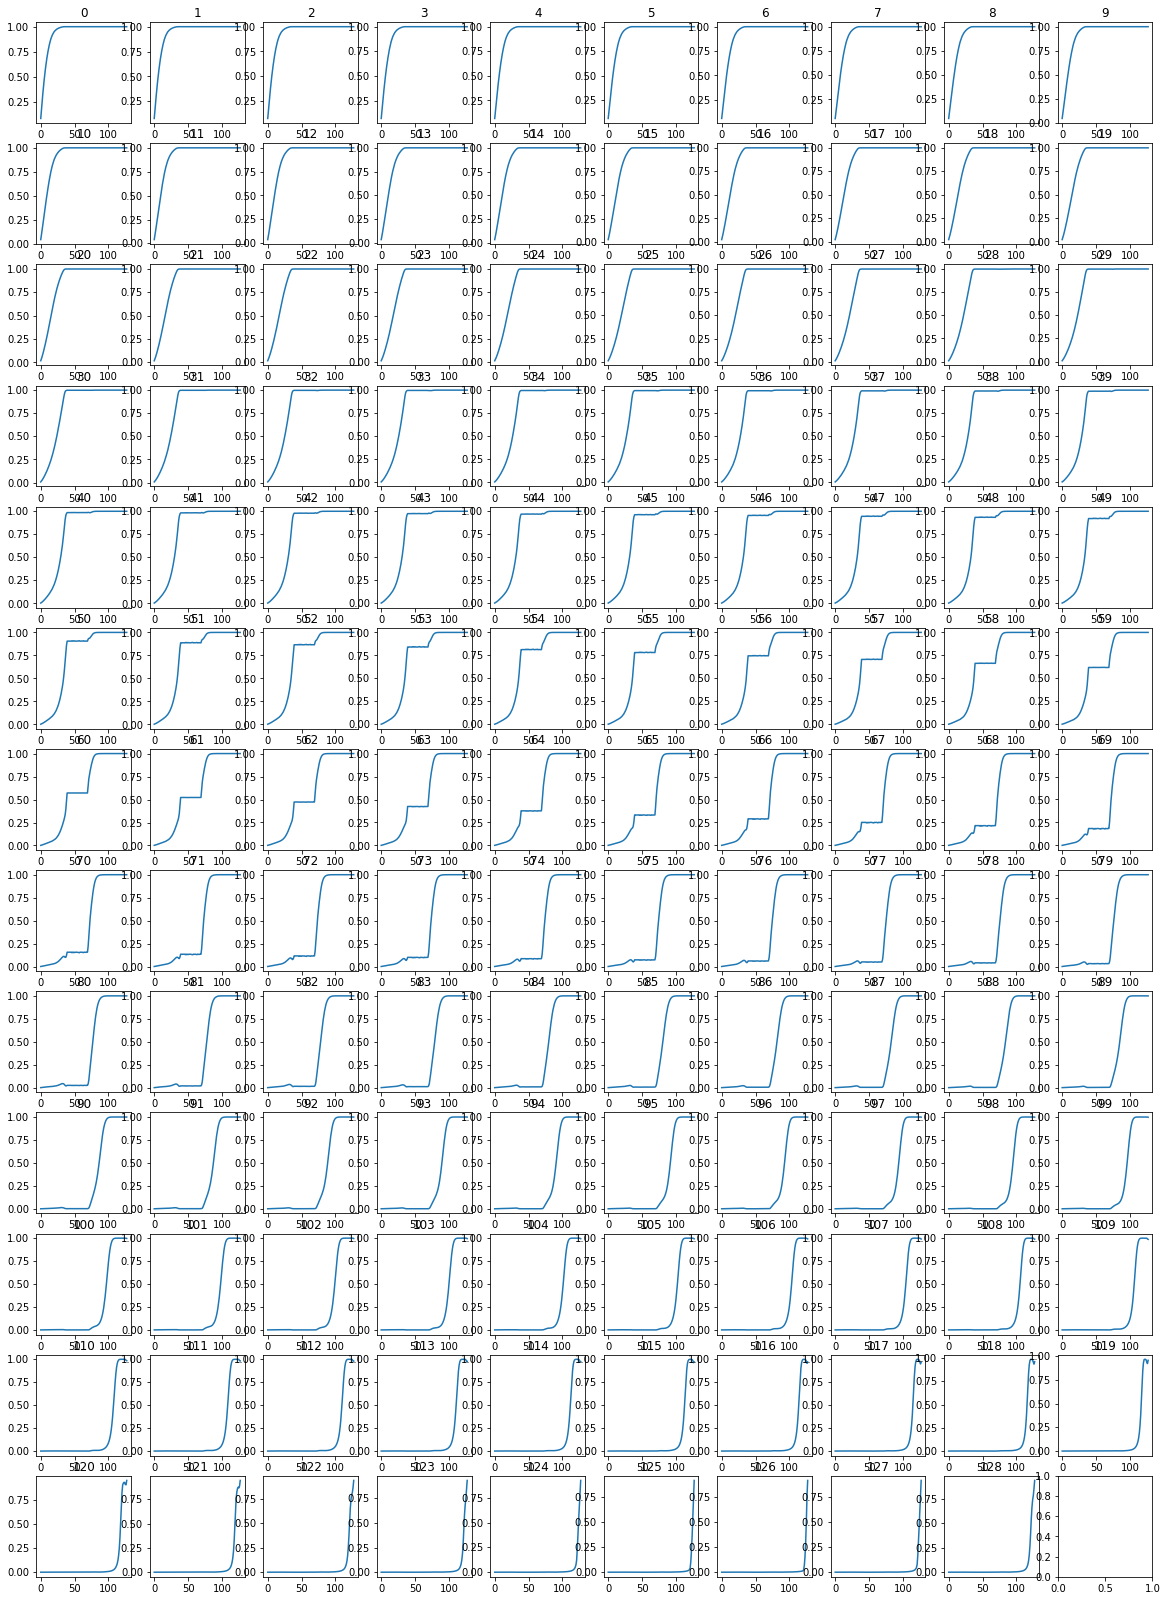

In [ ]:
#Partial :
activation_partial, X_predicted_partial = model_partial(X)
X_predicted_partial = X_predicted_partial.detach().numpy()
activation_partial = activation_partial.detach().numpy()
#print(X_predicted_partial[0])

full_visualization(X_predicted_partial)

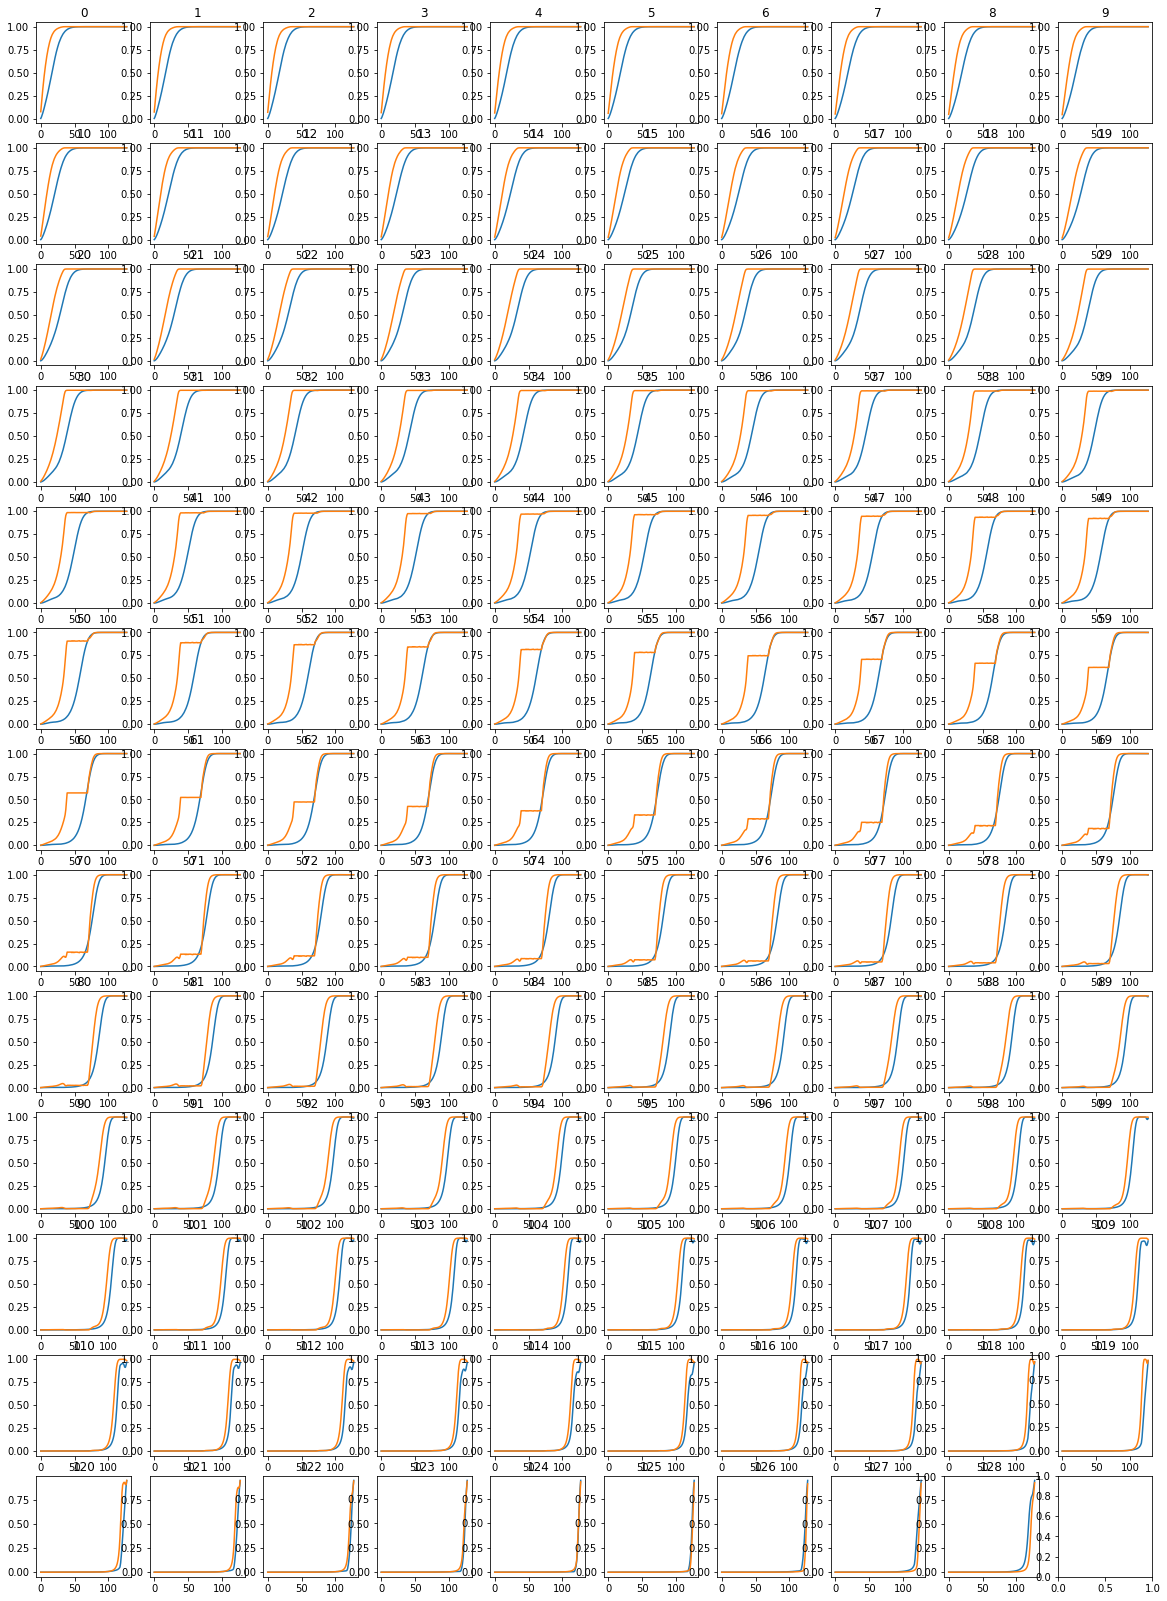

In [ ]:
full_visualization(X_predicted, X_predicted_partial)

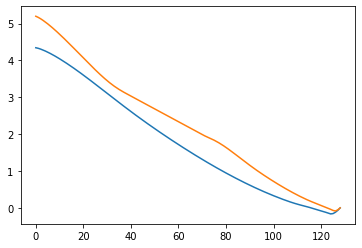

In [ ]:
#print(activation['fc1'].detach().numpy())
#plt.plot(activation['fc1'].detach().numpy())

plt.plot(activation_full)
plt.plot(activation_partial)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


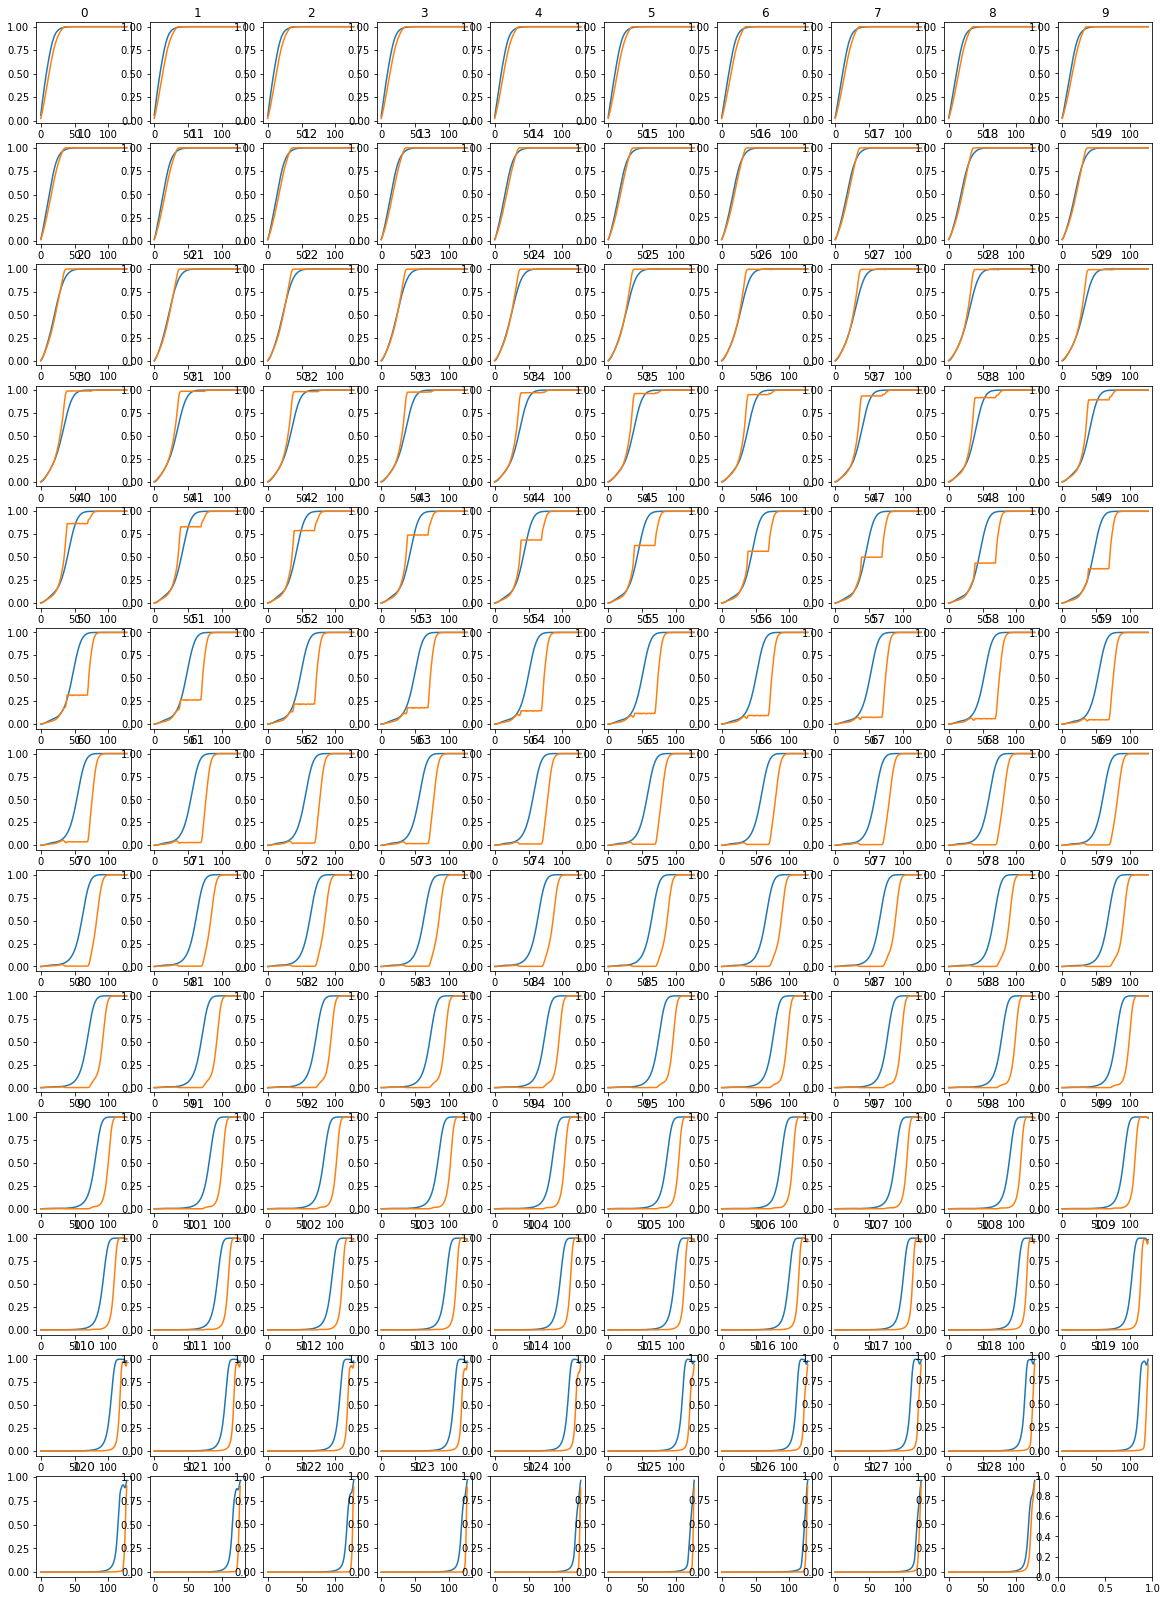

In [ ]:
X_predicted_Epart_Dfull = model.decoder(torch.tensor(activation_partial)).detach().numpy()
X_predicted_Efull_Dpart = model_partial.decoder(torch.tensor(activation_full)).detach().numpy()
full_visualization(X_predicted_Epart_Dfull,X_predicted_Efull_Dpart)

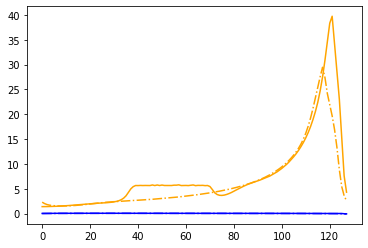

In [ ]:

plt.plot(model_partial.encoder.fc1.weight.detach().numpy()[0], color='blue')
plt.plot(model_partial.decoder.fc2.weight.detach().numpy(), color='orange')

plt.plot(model.encoder.fc1.weight.detach().numpy()[0], linestyle='-.', color='blue')
plt.plot(model.decoder.fc2.weight.detach().numpy(), linestyle='-.', color='orange')

plt.show()